# Exploring San Francisco Police Department Incident Reports

For detailed information about the dataset, please visit [their official website](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry).

### Downloading the data file

First we send a HTTP GET request and fetch the data

In [ ]:
import requests

download_file = requests.get('https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD')
if download_file.status_code != 200:
    print('Error while fetching the data')
else:
    print('Data successfully received')

Let's look at the location where this data will be saved.

In [ ]:
import os
import sys

filename = os.path.join(os.path.dirname(sys.argv[0]), download_file.headers['content-disposition'].split(';')[-1].strip().split('=')[-1])
print('Data will be saved in: ' + filename)

Now we save the data

In [ ]:
op_file = open(filename, 'wb')
op_file.write(download_file.content)
op_file.close()

### Reading the file in Spark

We'll be using Spark's DataFrame API. So let's initiate a SparkSession.

We're enabling the eager execution for Spark. This is enabled to get a good view of the DataFrame in the Notebook, which isn't possible after we call an action.
> NOTE: This isn't advised in case of production environment.

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('SF_Police_Dept_Incident_Statistics').config('spark.sql.repl.eagerEval.enabled', 'True').getOrCreate()

Loading the CSV file

In [97]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, LongType

schema = StructType([
                StructField('IncidntNum', IntegerType(), True)
                , StructField('Category', StringType(), True)
                , StructField('Descript', StringType(), True)
                , StructField('DayOfWeek', StringType(), True)
                , StructField('Date', StringType(), True)
                , StructField('Time', StringType(), True)
                , StructField('PdDistrict', StringType(), True)
                , StructField('Resolution', StringType(), True)
                , StructField('Address', StringType(), True)
                , StructField('X', DoubleType(), True)
                , StructField('Y', DoubleType(), True)
                , StructField('Location', StringType(), True)
                , StructField('PdId', LongType(), True)
            ])
input_data = spark.read.csv(filename, header=True, sep=',', schema=schema)

Let's see the top 5 rows of the DataFrame

In [4]:
input_data.limit(5)

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
110308742,MISSING PERSON,FOUND PERSON,Friday,04/15/2011,16:00,TARAVAL,LOCATED,0 Block of CRESPI DR,-122.476327815126,37.7196874952717,POINT (-122.47632...,11030874275000
90316914,WARRANTS,WARRANT ARREST,Thursday,03/26/2009,12:28,SOUTHERN,"ARREST, BOOKED",1000 Block of MAR...,-122.411339562557,37.7812707434494,POINT (-122.41133...,9031691463010
130132311,SECONDARY CODES,DOMESTIC VIOLENCE,Friday,02/15/2013,02:00,PARK,"ARREST, BOOKED",CASTRO ST / MARKE...,-122.435187699349,37.7626702770872,POINT (-122.43518...,13013231115200
80052833,OTHER OFFENSES,"DRIVERS LICENSE, ...",Tuesday,01/15/2008,20:13,MISSION,"ARREST, CITED",VALENCIA ST / 16T...,-122.421886357981,37.7649178909424,POINT (-122.42188...,8005283365016
70535770,SECONDARY CODES,DOMESTIC VIOLENCE,Saturday,05/26/2007,18:10,MISSION,"ARREST, BOOKED",2800 Block of FOL...,-122.413935404044,37.7516932889916,POINT (-122.41393...,7053577015200


Also, let's see the number of records in the file.

In [5]:
print('The file has', input_data.count(), 'records.')

The file has 2215024 records.


### Data Analysis using Spark

Let's analyse the available data.

##### What is the minimum (start) and the maximum (end) Date of the recorded incidents?

We learn how to cast STRING to DATE and then aggregate on it.

In [98]:
from pyspark.sql.functions import to_date, min, max

input_data.select(to_date('Date', format='MM/dd/yyyy').alias('Date')).agg(min('Date').alias('Start_Date'), max('Date').alias('End_Date'))

Start_Date,End_Date
2003-01-01,2018-05-15


##### The field 'IncidntNum', is it a key field for the complete DataFrame (unique for each row)?

We could have done a simple GroupBy and found that the field is not unique for each row. Instead, we showcased that some of the incidents have multiple records belonging to different Year, Category and Addresses.

In the process, we learnt many concepts like OrderBy, GroupBy, Filter, Join

In [99]:
from pyspark.sql.functions import to_date, year, countDistinct, greatest

inc_with_multiples = input_data.select('IncidntNum', year(to_date('Date', format='MM/dd/yyyy')).alias('Year'), 'Category', 'Address')\
                            .orderBy('IncidntNum')\
                            .groupBy('IncidntNum')\
                            .agg(countDistinct('Year').alias('Distinct_Years'), countDistinct('Category').alias('Distinct_Categories'), countDistinct('Address').alias('Distinct_Addresses'))\
                            .filter('Distinct_Years > 1 AND Distinct_Categories > 1 AND Distinct_Addresses > 1')\
                            .select('IncidntNum', greatest('Distinct_Years', 'Distinct_Categories', 'Distinct_Addresses').alias('Greatest'))\
                            .orderBy('IncidntNum')

input_data.select('IncidntNum', year(to_date('Date', format='MM/dd/yyyy')).alias('Year'), 'Category', 'Address')\
        .orderBy('IncidntNum')\
        .join(inc_with_multiples, 'IncidntNum')\
        .orderBy(['Greatest', 'IncidntNum', 'Year', 'Category', 'Address'], ascending=[0, 1, 1, 1, 1])\
        .select('IncidntNum', 'Year', 'Category', 'Address')

IncidntNum,Year,Category,Address
90068024,2009,ASSAULT,1500 Block of SUN...
90068024,2009,OTHER OFFENSES,1500 Block of SUN...
90068024,2009,OTHER OFFENSES,1500 Block of SUN...
90068024,2009,SECONDARY CODES,1500 Block of SUN...
90068024,2009,WEAPON LAWS,1500 Block of SUN...
90068024,2009,WEAPON LAWS,1500 Block of SUN...
90068024,2010,ASSAULT,800 Block of BRYA...
90068024,2010,ASSAULT,800 Block of BRYA...
90068024,2010,WEAPON LAWS,800 Block of BRYA...
90327438,2009,DRUG/NARCOTIC,400 Block of MINN...


##### Performance Optimisation

While performing the above analysis, it was noted that some of the operations will be repeated everytime we perform any analysis. Thus, it's a good practice to prepare and cache an intermediate DataFrame with all these operations and the required fields.

Why should one cache the repititive intermediate DataFrame?
* Reading from memory or disk is faster than reading from any other source. We shouldn't hit the source multiple times but only once.
* Huge performance benefits are achieved as we save time and resources which would have been usually spent in recomputing the repetitive transformations and aggregations.

Now, the operations which we'll cache include:
* Getting DateTime: Concatenating the fields 'Date' and 'Time' and then casting it to a TIMESTAMP field.
* Incomplete Year: Since we don't have the complete data for the year 2018, we filter out all the records for that year so that any analysis on annual KPIs are accurate.
* One row for each IncidntNum: We'll rank the records of each Incident in the order of DateTime. Then, we'll filter to consider only the earliest record and discard others.

In [100]:
from pyspark.sql import Window
from pyspark.sql.functions import concat_ws, to_timestamp, row_number

df = input_data.select('IncidntNum', to_timestamp(concat_ws(' ', 'Date', 'Time'), format='MM/dd/yyyy HH:mm').alias('DateTime'), 'Category', 'PdDistrict', 'X', 'Y')\
            .filter(year('DateTime') != 2018)\
            .orderBy(['IncidntNum', 'DateTime'])\
            .withColumn('Rank', row_number().over(Window.partitionBy('IncidntNum').orderBy('DateTime')))\
            .filter('Rank == 1')\
            .select('IncidntNum', 'DateTime', 'Category', 'PdDistrict', 'X', 'Y')

df.cache().limit(5)

IncidntNum,DateTime,Category,PdDistrict,X,Y
259633,2005-09-26 13:11:00,WARRANTS,INGLESIDE,-122.438294025226,37.7171370303947
879366,2004-07-29 11:30:00,WARRANTS,NORTHERN,-122.421873869345,37.7801318773016
21371258,2004-07-03 08:40:00,WARRANTS,SOUTHERN,-122.406690592261,37.7852071918419
30002907,2003-01-01 17:48:00,NON-CRIMINAL,TENDERLOIN,-122.412596970637,37.7811192121542
30005309,2003-01-02 05:00:00,VANDALISM,TARAVAL,-122.504330609859,37.7530101139206


##### How did the Incident Count change over Time?

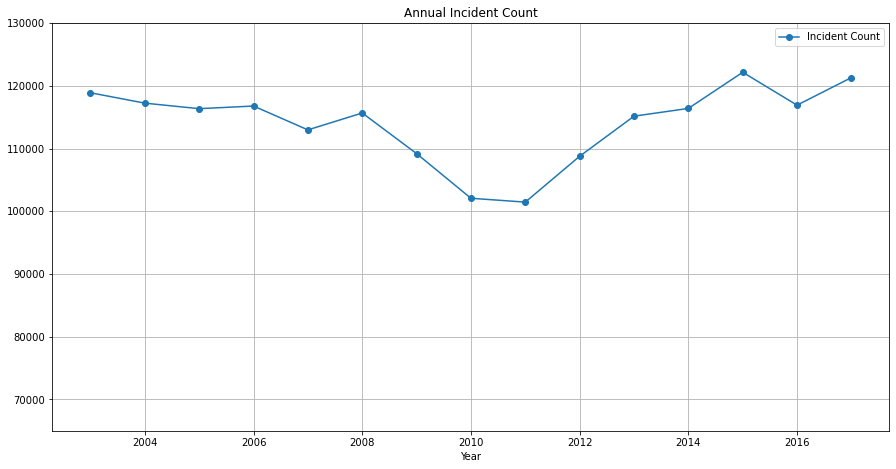

In [101]:
%matplotlib inline

from pyspark.sql.functions import count

op = df.select(year('DateTime').alias('Year')).orderBy('Year').groupBy('Year').agg(count('Year').alias('Incident Count'))\
        .toPandas().set_index('Year').plot(kind='line', figsize=(15, 7.5), title='Annual Incident Count', marker='o', grid=True, ylim=(65000, 130000))

##### What time of the day observes a peak / dip in the Incident Count?

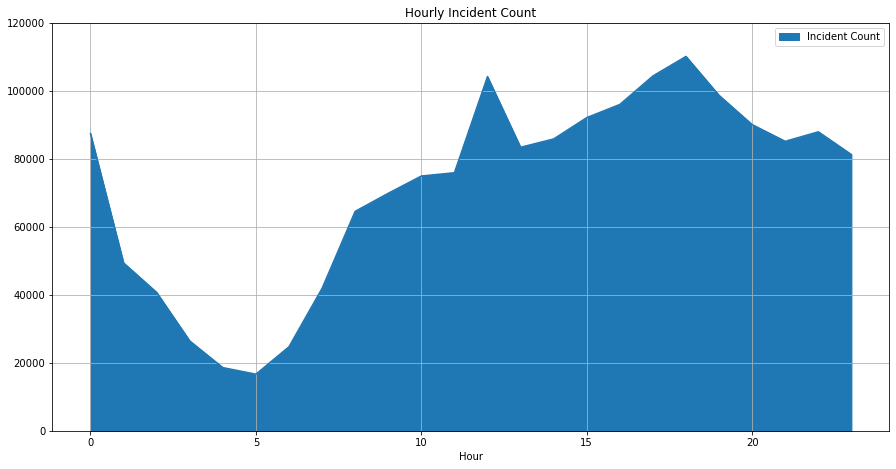

In [102]:
%matplotlib inline

from pyspark.sql.functions import hour

op = df.select(hour('DateTime').alias('Hour')).orderBy('Hour').groupBy('Hour').agg(count('Hour').alias('Incident Count'))\
        .toPandas().set_index('Hour').plot(kind='area', figsize=(15, 7.5), title='Hourly Incident Count', grid=True, ylim=(0, 120000))

##### Which category of the incidents are recorded the most?

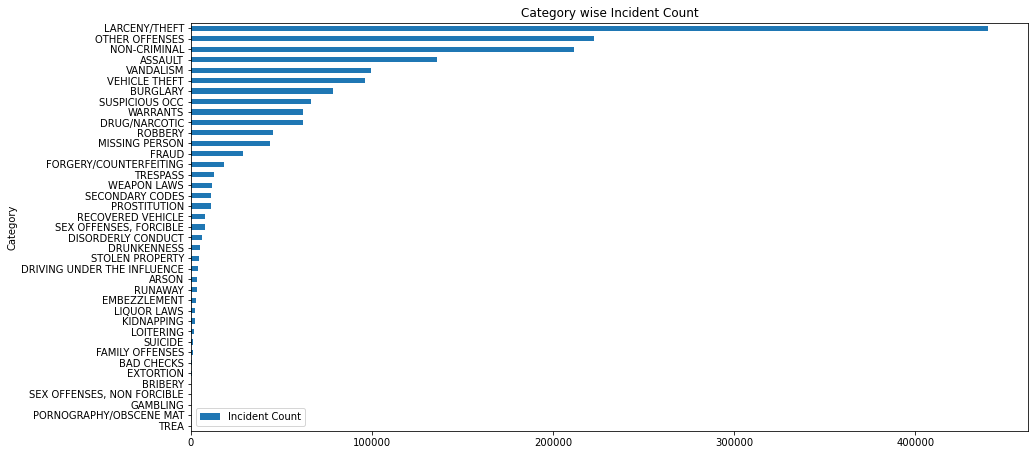

In [103]:
%matplotlib inline

from pyspark.sql.functions import hour

op = df.select('Category').orderBy('Category').groupBy('Category').agg(count('Category').alias('Incident Count')).orderBy('Incident Count')\
        .toPandas().set_index('Category').plot(kind='barh', figsize=(15, 7.5), title='Category wise Incident Count')

##### Which district records the highest incidents?

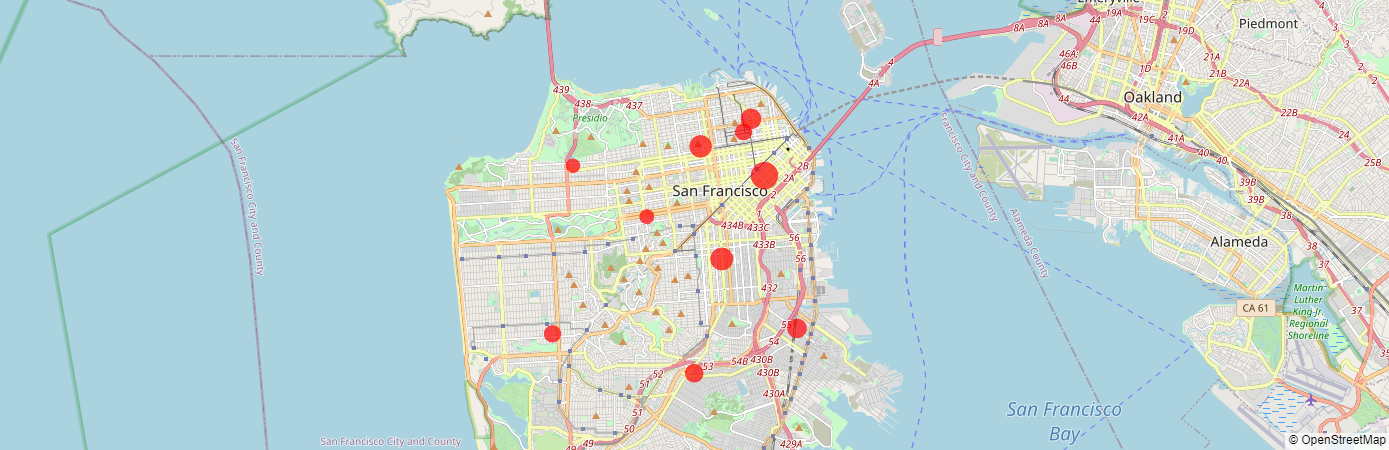

In [104]:
import plotly.express as px
from pyspark.sql.functions import avg

pd_df = df.select('PdDistrict', 'X', 'Y')\
        .filter('PdDistrict <> \'null\'')\
        .orderBy('PdDistrict')\
        .groupBy('PdDistrict')\
        .agg(avg('X').alias('X_Avg'), avg('Y').alias('Y_Avg'), count('PdDistrict').alias('Incident_Count'))\
        .toPandas()

fig = px.scatter_mapbox(pd_df, lat='Y_Avg', lon='X_Avg', size='Incident_Count', hover_name='PdDistrict', zoom=11, color_discrete_sequence=["red"])
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

##### Which categories have observed growth over time?

To perform this analysis, we create a Temporary View out of our DataFrame and query it using SQL. We also learn to pivot the DataFrame for better visualization.

In [105]:
df.createOrReplaceTempView('DATA')

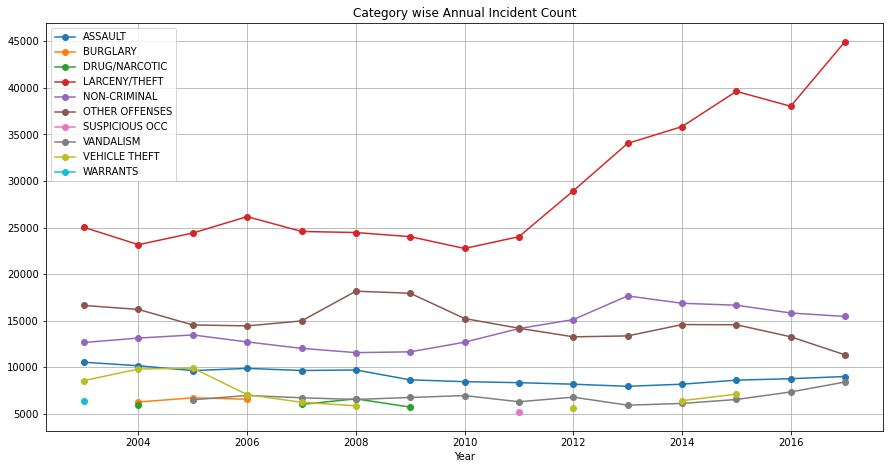

In [146]:
%matplotlib inline

spark.sql("""
SELECT
    Year
    , Category
    , Incident_Count
FROM
    (
        SELECT
            *
            , (Incident_Count / (sum(Incident_Count) over(PARTITION BY Year))) AS Per_Share
        FROM
            (
                SELECT
                    year(DateTime) AS Year
                    , Category
                    , count(1) AS Incident_Count
                FROM
                    DATA
                GROUP BY
                    Year, Category
            )
    )
WHERE
    Per_Share >= 0.05
ORDER BY
    Year
""").groupBy('Year').pivot('Category').sum('Incident_Count')\
.toPandas().set_index('Year').plot(kind='line', figsize=(15, 7.5), title='Category wise Annual Incident Count', marker='o', grid=True)